In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
%matplotlib inline

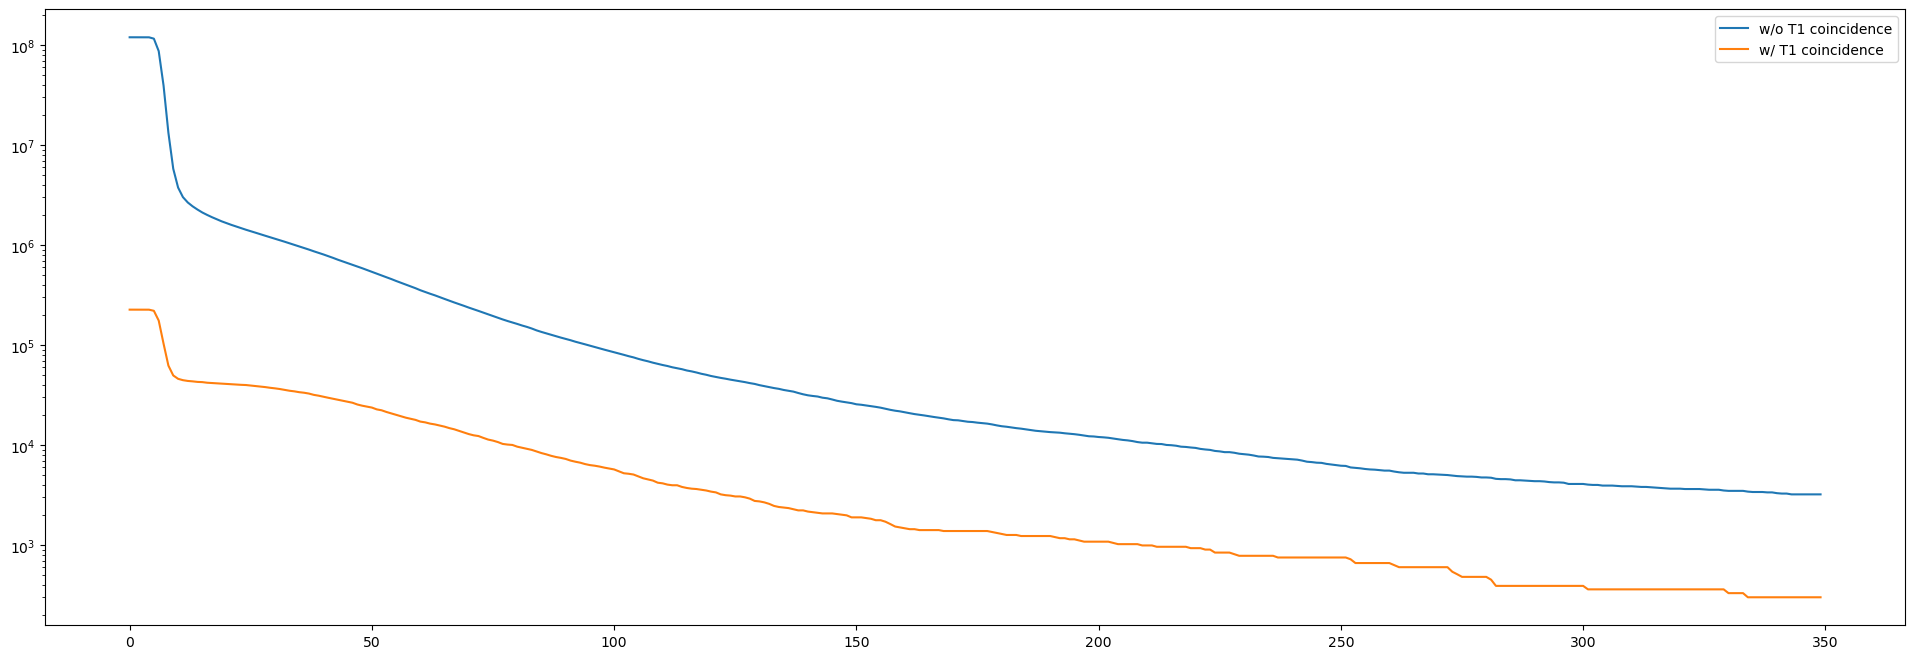

In [70]:
all_rates_t1 = np.zeros(350)
all_rates = np.zeros(350)

for file in os.listdir("/cr/tempdata01/filip/SSDCalib/UubRates/NuriaPilot/with_T1"):
    try:
        all_rates_t1 += np.loadtxt("/cr/tempdata01/filip/SSDCalib/UubRates/NuriaPilot/with_T1/" + file)
    except FileNotFoundError: pass

for file in os.listdir("/cr/tempdata01/filip/SSDCalib/UubRates/NuriaPilot/without_T1"):
    try:
        all_rates += np.loadtxt("/cr/tempdata01/filip/SSDCalib/UubRatesNuriaPilot/without_T1/" + file)
    except FileNotFoundError: pass

# convert number of traces to rate
all_rates_t1 /= (800 * 5000 * 8.33e-9)
all_rates /= (800 * 5000 * 8.33e-9)

# def background(x):
#     return A * np.exp(-mu * (x-x_min))
# 
# all_rates = all_rates / (5000 * 800) 
# x_min, x_max = np.argmin(np.diff(all_rates)) + 5, 100
# A = all_rates[x_min]
# mu = -np.log(all_rates[x_max] / A) / (x_max - x_min)
# residuals = all_rates[x_min:x_max] - background(np.arange(x_min,x_max,1))


plt.plot(range(350), all_rates, label = "w/o T1 coincidence")
plt.plot(range(350), all_rates_t1, label = "w/ T1 coincidence")
plt.yscale("log")
plt.legend()

### It seems rates without the T1 cut are waay too high
### Let's ty estimating the MIP peak before coming to conclusions

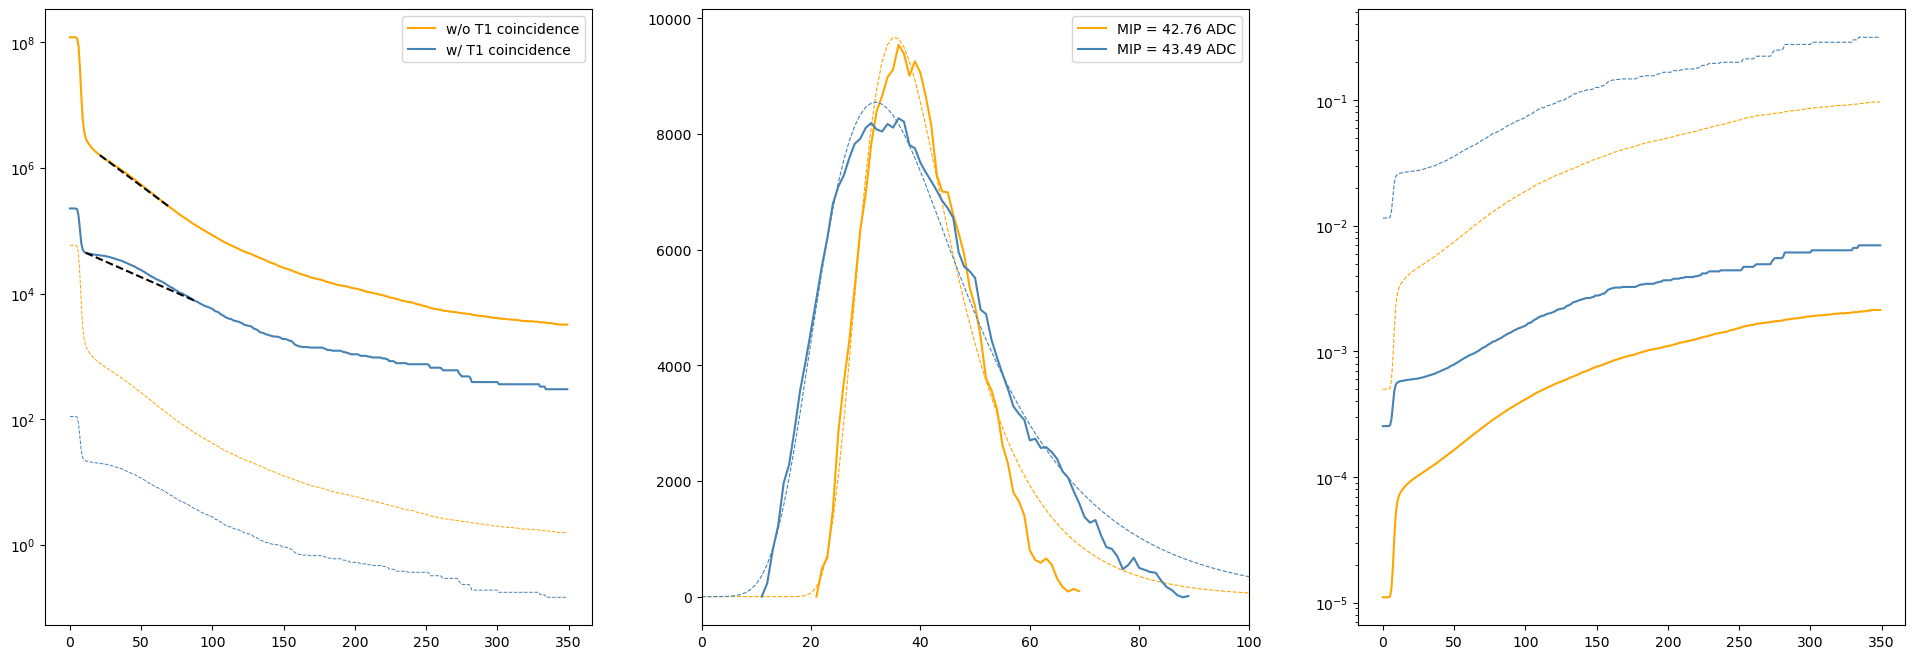

In [75]:
from scipy.optimize import curve_fit
import scipy.stats as stats

def background(x):
    return A * np.exp(-mu * (x-x_min))

def landau(x, factor, loc, scale):
    return stats.moyal(loc=loc,scale=scale).pdf(x) * factor

loc, scale, factor = 32, 10, 160                                    # good first guesses
plt.rcParams["figure.figsize"] = [24,8]
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3)

for rate in [all_rates, all_rates_t1]:

    offset = 15 if rate[0] > 1e6 else 5
    end = 90 if rate[0] < 1e6 else 70
    scaling = 1 if rate[0] < 1e6 else 0.2
    color = "steelblue" if rate[0] < 1e6 else "orange"

    x_min, x_max = np.argmin(np.diff(rate)) + offset, end
    A = rate[x_min]
    mu = -np.log(rate[x_max] / A) / (x_max - x_min)
    residuals = rate[x_min:x_max] - background(np.arange(x_min,x_max,1))

    ax1.plot(range(350), rate, c = color)
    ax1.plot(range(350), rate / 2048, c = color, ls='--', lw=0.7)

    ax1.plot(range(x_min, x_max), background(range(x_min, x_max)), c = "k", ls = "--")

    popt, pcov = curve_fit(landau, range(x_min, x_max), residuals, [factor, loc, scale])

    ax2.plot(range(x_min, x_max), scaling * residuals, c = color)
    ax2.plot(range(350), scaling * landau(range(350), *popt), ls='--', lw=0.8, c = color)

    mean = stats.moyal(*popt[1:]).mean()

    ax2.plot([], [], c=color, label=f'MIP = {mean:.2f} ADC')

    ax3.plot(range(350), 1/np.sqrt(rate*(800 * 5000 * 8.33e-9 * 2048)), c=color)
    ax3.plot(range(350), 1/np.sqrt(rate*(800 * 5000 * 8.33e-9)), c=color, ls="--", lw=0.8)


ax3.set_yscale("log")
ax2.set_xlim(0,100)
ax1.set_yscale("log")
ax1.plot([], [], c='orange', label='w/o T1 coincidence')
ax1.plot([], [], c="steelblue", label = "w/ T1 coincidence")
ax1.legend()
ax2.legend()